Load and Preprocessing

In [37]:
import os
import numpy as np
import librosa
import pickle

def extract_features(file_path, sample_rate=16000, n_mfcc=13):
    try:
        # Load the audio file
        audio, sr = librosa.load(file_path, sr=sample_rate)
        
        # Extract MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        
        # Take the mean of the MFCCs to get a fixed-size vector
        mfccs_mean = np.mean(mfccs.T, axis=0)
        
        return mfccs_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Preprocess dataset
def preprocess_dataset(data_folder):
    features, labels = [], []
    
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                label = os.path.basename(root)  # Assume folder name is the label
                
                # Extract features from the audio file
                mfcc_features = extract_features(file_path)
                if mfcc_features is not None:
                    features.append(mfcc_features)
                    labels.append(label)
    
    return np.array(features), np.array(labels)

# Example usage
data_folder = '../Audio_Classification_CNN/dataset'  # Update with the correct path
X, y = preprocess_dataset(data_folder)

# Save preprocessed features
with open('features.pkl', 'wb') as f:
    pickle.dump((X, y), f)


Data Augmentation

In [38]:
def augment_audio(file_path, sample_rate=16000):
    audio, sr = librosa.load(file_path, sr=sample_rate)
    
    # Pitch shifting
    pitch_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)  # Shift pitch by 2 semitones
    
    # Time stretching
    time_stretched = librosa.effects.time_stretch(audio, rate=1.25)  # Speed up by 25%
    
    return pitch_shifted, time_stretched

# Example augmenting a file
augmented_files = []
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            pitch_shifted, time_stretched = augment_audio(file_path)
            augmented_files.append((pitch_shifted, time_stretched))

Train DNN Model


In [39]:
import os
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load preprocessed data
with open('features.pkl', 'rb') as f:
    X, y = pickle.load(f)

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Build the DNN model
model = Sequential()
model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_test, y_test))

# Save the model and training history
model.save('speaker_dependent_dnn_model.h5')
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/300


c:\Users\reinj\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3624 - loss: 31.7699 - val_accuracy: 0.5000 - val_loss: 3.4864
Epoch 2/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3799 - loss: 20.0947 - val_accuracy: 0.4262 - val_loss: 4.6272
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4145 - loss: 13.7895 - val_accuracy: 0.4426 - val_loss: 4.6565
Epoch 4/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4016 - loss: 10.4017 - val_accuracy: 0.5820 - val_loss: 0.9581
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4039 - loss: 6.8062 - val_accuracy: 0.4836 - val_loss: 1.1906
Epoch 6/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4309 - loss: 5.0329 - val_accuracy: 0.4344 - val_loss: 0.9941
Epoch 7/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4535 - loss: 3.5999 - val_accuracy: 0.5328 - val_loss: 1.0134
Epoch 8/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4127 - loss: 3.1562 - val_accuracy: 0.5246 - val_loss:

Evaluate Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7866 - loss: 0.7223  
Test Loss: 0.8553250432014465
Test Accuracy: 0.7868852615356445


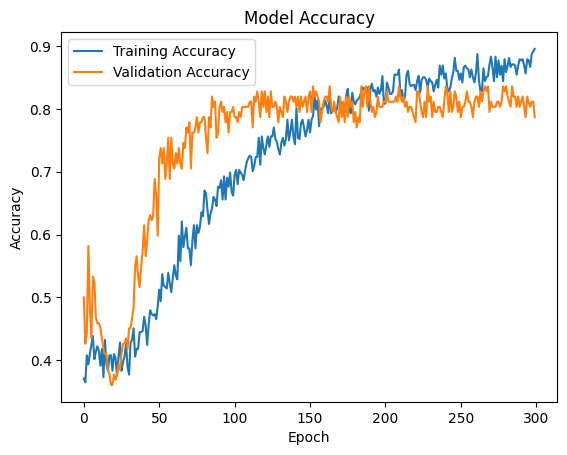

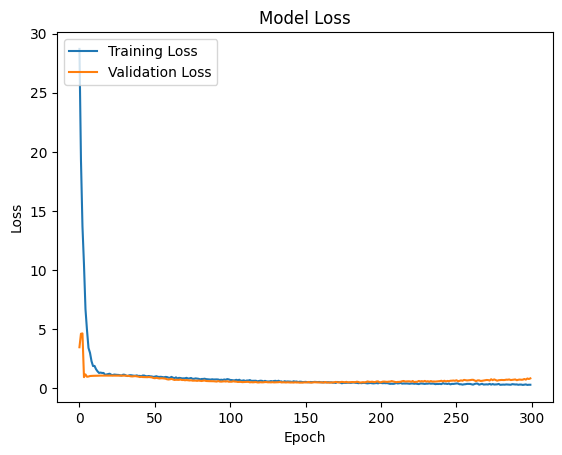

In [40]:
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('speaker_dependent_dnn_model.h5')

# Load the training history
with open('training_history.pkl', 'rb') as f:
    history = pickle.load(f)

# Load preprocessed data for testing
with open('features.pkl', 'rb') as f:
    X, y = pickle.load(f)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode the labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Evaluate the model on test data
evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Plot training & validation accuracy values
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Prediction

In [42]:
# Function to predict a new audio file
def predict_audio(file_path, model, le):
    mfcc_features = extract_features(file_path)
    if mfcc_features is not None:
        mfcc_features = np.expand_dims(mfcc_features, axis=0)  # Add batch dimension
        predictions = model.predict(mfcc_features)
        predicted_label = le.inverse_transform([np.argmax(predictions)])
        return predicted_label
    return None

# Load the trained model
from tensorflow.keras.models import load_model
model = load_model('speaker_dependent_dnn_model.h5')

# Predict an example audio file
file_path = 'test_dataset'
for root, dirs, files in os.walk(file_path):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            predicted_label = predict_audio(file_path, model, le)
            print(f"Audio file: {file}")
            print(f"Predicted label: {predicted_label}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Audio file: 00b01445_nohash_0.wav
Predicted label: ['bird']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Audio file: 00f0204f_nohash_1.wav
Predicted label: ['bird']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Audio file: 00f0204f_nohash_3.wav
Predicted label: ['bird']
